In [45]:
#!/usr/bin/env python
# coding: utf-8
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.nn import TransformerEncoder, TransformerEncoderLayer

import torchtext
from torchtext import data, datasets
from torchtext.vocab import FastText

import os
import math
import MeCab
import shutil

device="cuda:0" if torch.cuda.is_available() else "cpu"
SEED = 1
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
mecab = MeCab.Tagger("-Owakati")

# BLEU

from Util.selfbleu import CalcSelfBLEU
from Util.bleu import calc_all_bleu

from matplotlib import pyplot as plt
%matplotlib inline

In [46]:
import torchwordemb
w2v, vec = torchwordemb.load_word2vec_text('./data/vector/model.vec')


In [47]:
# HYPER PARAMETER
BATCH_SIZE=100
EMBED_SIZE=300
LSTM_HIDDEN_SIZE=300
KL_START_EPOCH=15
AE_EPOCHS=100
REPORT_INTERVAL=1
ae_lr=1e-2

In [48]:
# LABEL NAME
data_source="wiki"
feature="only_ja_small"
feature="only_ja_sample"
# data_source="orphans"
# feature="all"

log_dir='./log/{}/'.format("_".join(["train",data_source,feature]))
if os.path.isdir(log_dir):
    shutil.rmtree(log_dir)
os.mkdir(log_dir)

In [49]:
if data_source=="wiki" or data_source=="orphans":
    MAX_LEN=20 #paddingをバッチにかかわらず固定長にする
    TEXT = data.Field(sequential=True, lower=True, include_lengths=True, init_token="<SOS>",eos_token="<EOS>", fix_length=MAX_LEN, batch_first=True)
    train, val, test = data.TabularDataset.splits(
        path='./data/foruse', train="_".join(["train",data_source,feature])+'.tsv',
        validation="_".join(["eval",data_source,feature])+'.tsv',test="_".join(["test",data_source,feature])+'.tsv', 
        format='tsv',
        fields=[('Text', TEXT),])
#     TEXT.build_vocab(train, vectors=FastText(language="ja"))
    TEXT.build_vocab(train)
    TEXT.vocab.set_vectors(stoi=w2v, vectors=vec, dim=300)
    train_iter, val_iter, test_iter = data.Iterator.splits((train, val, test), batch_sizes=(BATCH_SIZE, BATCH_SIZE, BATCH_SIZE),sort = False, device=torch.device(device))
    vocab_size=TEXT.vocab.vectors.size()[0]

In [50]:
share_conv=nn.Embedding(vocab_size, EMBED_SIZE).to(device)
share_conv.weight.data.copy_(TEXT.vocab.vectors)
share_conv.weight.requires_grad = False

In [51]:
class Encoder(nn.Module):
    def __init__(self,embed_size,n_hid):
        super().__init__()
        self.lstm = nn.LSTM(input_size = embed_size,
                            hidden_size = n_hid,
                            batch_first=True)
        
    def forward(self, x):
        """
        input: 
            x = (batch, max_len, embed_dim)
        output:
            x = (batch, hidden_size)
        """
        _, (h,c)=self.lstm(x) # h=(max_len, batch, n_hid)
        return (h,c)

In [52]:
class vae_classifier_2layer(nn.Module):
    def __init__(self,n_hid):
        super().__init__()
        self.fc = nn.Linear(n_hid*2, n_hid)
        self.fcmean = nn.Linear(n_hid, n_hid)
        self.fcvar = nn.Linear(n_hid, n_hid)
        self.ReLU=nn.ReLU()
        self.lnorm=nn.LayerNorm(n_hid)

    def forward(self, hidden):# h,c = (batch, hidden_size)
        h, c = hidden
        tmp = self.ReLU(self.lnorm(self.fc(torch.cat([h,c],dim=-1))))
        mean = self.fcmean(tmp)
        log_sigma_sq = self.fcvar(tmp)
        return mean, log_sigma_sq


In [53]:
class Decoder(nn.Module):
    def __init__(self,embed_size,n_hid,max_len,vocab_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size = embed_size,
                            hidden_size = n_hid,
                            batch_first=True)
        self.fc = nn.Linear(n_hid, vocab_size)
        self.embed_size=embed_size
        self.max_len=max_len
        self.embedding=share_conv
        
    def forward(self, hidden, x, teacher):
        """
        input:
            x_emb=(batch, hidden_size, embedding_size)
        output:
            logits = (batch, max_len, vocab_size)
            sentence = (batch, max_len) : 中身はindex
        """
        logits = torch.tensor([]).to(device)
        sentence = torch.tensor([],dtype=torch.long).to(device)
        
        for i in range(self.max_len):
            if torch.rand(1)<1/3:
                # word dropout
                tmp=torch.zeros(len(x), 1, self.embed_size).to(device)
            elif teacher or i==0:
                tmp = torch.unsqueeze(x[:,i,:],1) # tmp = (batch, 1, embed_dim)
            else:
                # word = (batch, 1, 1)
                tmp = self.embedding(word) # tmp = (batch, 1, embed_dim)
                tmp = F.normalize(tmp)
            x_input = tmp # x_input = (batch, 1, (embed_size + n_hid))
            out, hidden = self.lstm(x_input, hidden)
                # out = (batch, 1, n_hid)
                # hidden = ((batch, 1, n_hid),(batch, 1, n_hid))
            logit = self.fc(out) # logit = (batch, 1, vocab_size)
            word = torch.argmax(logit, dim=2) # word = (batch, 1)

            sentence = torch.cat([sentence, word],1)
            logits = torch.cat([logits,logit],1)   
        return logits, sentence

In [54]:
class AutoEncoder(nn.Module):
    def __init__(self,maxlen):
        super().__init__()
        self.n_hid=LSTM_HIDDEN_SIZE
        self.maxlen=maxlen
        self.encoder=Encoder(embed_size=EMBED_SIZE,n_hid=self.n_hid)
        self.vae_classifer=vae_classifier_2layer(n_hid=self.n_hid)
        self.decoder=Decoder(embed_size=EMBED_SIZE,n_hid=self.n_hid,max_len=MAX_LEN,vocab_size=vocab_size)
        self.embedding=share_conv
        self.fc1 = nn.Linear(self.n_hid, self.n_hid)
        self.fc2 = nn.Linear(self.n_hid, self.n_hid)
        
    def forward(self, x): # x=(batch, max_len)
        x_emb=self.embedding(x)  # x_emb = (batch, maxlen, embed_dim)
        x_emb = F.normalize(x_emb)
        
        hidden = self.encoder(x_emb) # h,c = (1, batch, hidden_size)
        mean, log_sigma_sq=self.vae_classifer(hidden)
        eps = torch.empty(len(x), self.n_hid).normal_(mean=0,std=1).to(device) # N(0, 1)
        h = mean + eps * torch.sqrt(torch.exp(log_sigma_sq)) # H_dec = (1, batch, n_gan)
        h,c=self.fc1(h), self.fc2(h)
        logits, sentence = self.decoder((h,c), x_emb, teacher=True)
        
        # loss
        criterion = nn.CrossEntropyLoss(ignore_index=1)
        loss = 0
        for i in range(self.maxlen-1):
            # <SOS>を除くためindexをずらす
            loss += criterion(torch.squeeze(logits[:,i,:]), torch.squeeze(x[:,i+1]))
        loss/=(self.maxlen-1)
        
        # KL loss
        # 標準正規分布と(μ,σ^2)正規分布を仮定しているので以下の計算式になる
        # nn.klDivLossを使うと仮定が甘い
        # kl_loss = Σ0.5Σ(μ^2+exp(ln(σ^2))-ln(σ^2)-1)を使う
        kl_loss = torch.sum(0.5 * torch.sum((mean**2 + torch.exp(log_sigma_sq) - log_sigma_sq - 1),dim=1))
        if epoch>KL_START_EPOCH:
            loss += (epoch-KL_START_EPOCH)/(AE_EPOCHS-KL_START_EPOCH)*kl_loss
        
        return loss, sentence


In [55]:
def change_to_sent(sents,j):
    word_list=[]
    for i in sents[j]:
        if i==TEXT.vocab.stoi["<EOS>"]:
            break
        if i!=TEXT.vocab.stoi["<PAD>"]:
            word_list.append(TEXT.vocab.itos[int(i)])
    return word_list

def write_out(url, origin_sents, syn_sents):
    with open(url, "w") as f:
        for j in range(len(syn_sents)):
            f.write("input : "+" ".join(change_to_sent(origin_sents,j))+"\n")
            f.write("output: "+" ".join(change_to_sent(syn_sents,j))+"\n")

In [56]:
def train():
    auto_encoder.train()
    epoch_loss = 0
    count=0
    for idx, batch in enumerate(train_iter):
        (x, x_l) = batch.Text
            # xには文章のID表現が、x_lにはxの単語数が入る
            # x=(batch, max_len)
#         if len(x)!=BATCH_SIZE:break
        optimizer.zero_grad()
        loss, syn_sents=auto_encoder(x)        
        with torch.autograd.detect_anomaly():
            loss.backward()
            optimizer.step()
        epoch_loss+=loss.item()
        count+=1
        
    sample_x=x[0][1:]
    source_sentence=' '.join([TEXT.vocab.itos[int(i)] for i in sample_x if i != 1])
    gen_sentence=' '.join([TEXT.vocab.itos[int(i)] for i in syn_sents[0] if i != 1])

    write_out(log_dir+"{:03}.txt".format(epoch), x[:,1:], syn_sents)

    history_train.append(epoch_loss/count)
    if (epoch+1) % REPORT_INTERVAL==0:
        print("epoch: "+str(epoch+1)+'/'+str(AE_EPOCHS)+' ')
        print("training loss: "+str(history_train[epoch]))
#         print("kl_loss: "+str(kl_loss))
        print("source(train): "+str(source_sentence))
        print("result(train): "+str(gen_sentence))


In [57]:
'''
学習を始める
'''
print("start train...")
auto_encoder=AutoEncoder(maxlen=MAX_LEN)
auto_encoder.to(device)
optimizer = optim.Adam(auto_encoder.parameters(), lr=ae_lr)
history_train=[]
history_eval=[]

for epoch in range(AE_EPOCHS):
    train()

start train...
epoch: 1/100 
training loss: 5.870830535888672
source(train): 地球 以外 に 生命 が 発見 さ れ た 事例 は 記録 さ れ て い ない <EOS>
result(train): や や 品 石材 語 日本語 れ を を 日本語 こと を を 日本語 について 石材 どの どの にかけて にかけて
epoch: 2/100 
training loss: 5.4762372970581055
source(train): 事物 の 分布 を 考察 する にあたって 分布 図 の 作成 が 挙げ られる <EOS>
result(train): この この <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
epoch: 3/100 
training loss: 4.474201202392578
source(train): ただし 厳密 な 正書法 は なく 表記 の ゆれ は 広く 許容 さ れ て いる <EOS>
result(train): この の <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
epoch: 4/100 
training loss: 4.330178260803223
source(train): 年代 により さまざま な 日本語 の 表記 が 行わ れ て いる <EOS>
result(train): この この の の の の の の の の <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>
epoch: 5/100 
training loss: 4.153068542480469
source(train): すなわち 体系 は 下記 の よう に まとめ られ た <EOS>
result(train): この は は は は 

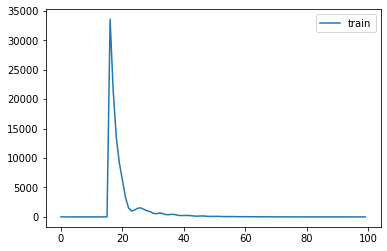

In [58]:
x = [i for i in range(len(history_train))]
plt.plot(x, history_train, label="train")
# plt.plot(x, history_eval, label="eval")
plt.legend()
plt.show()

## fasttext確認用

In [49]:
if torch.rand(1)<1/3:
    print("True")

True


In [7]:
nihongo_id=4

In [33]:
nihongo_id+=1
norm_list=[]
word=TEXT.vocab.itos[nihongo_id]
nihongo_vector=share_conv.weight[nihongo_id]
for i, val in enumerate(share_conv.weight):
    cos=torch.nn.CosineSimilarity(dim=0)
    diff=cos(nihongo_vector,val)
    norm=torch.norm(diff)
    norm_list.append((norm,i))
norm_list.sort(reverse=True)
print("「"+word+"」の似ている単語")
for i in range(1,11):
    val=norm_list[i][0]
    id_=norm_list[i][1]
    print(TEXT.vocab.itos[id_]+":"+str(val))

「その」の似ている単語
この:tensor(0.7487, device='cuda:0', grad_fn=<NormBackward0>)
の:tensor(0.6892, device='cuda:0', grad_fn=<NormBackward0>)
が:tensor(0.6426, device='cuda:0', grad_fn=<NormBackward0>)
た:tensor(0.6121, device='cuda:0', grad_fn=<NormBackward0>)
それ:tensor(0.6105, device='cuda:0', grad_fn=<NormBackward0>)
これ:tensor(0.6037, device='cuda:0', grad_fn=<NormBackward0>)
も:tensor(0.5796, device='cuda:0', grad_fn=<NormBackward0>)
を:tensor(0.5789, device='cuda:0', grad_fn=<NormBackward0>)
しかし:tensor(0.5774, device='cuda:0', grad_fn=<NormBackward0>)
に:tensor(0.5679, device='cuda:0', grad_fn=<NormBackward0>)


In [82]:
with open("./data/foruse/"+"_".join(["train",data_source,feature])+'.tsv') as f:
    c=0
    for i in f:
        c+=1
print(c)

86188
